In [1]:
# %%
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import joblib
# local imports
from editor.data_manipulation import load_train_val_test_set
from editor.data_visualisation import (
    plot_calibration_curves,
    plot_ROC_PRC_conf,
    plot_train_feature_correlation,
    plot_model_feature_importances
)
from editor.model_v3 import vectorise_data, get_v3_data_from_v2

TRAIN = False

FILE_PATH = 'data/vectorised_features_v3.csv'
# look whether data was vectorised and load data
if not os.path.exists(FILE_PATH):
    # id data v2 exists, it is easier
    if os.path.exists('data/vectorised_features_v2.csv'):
        vectorised_data = get_v3_data_from_v2()
    # if it doesn't it is necessary to vectorise them
    else:
        data = pd.read_csv(
            'data/data.csv', usecols=['full_text']
        )
        vectorised_data = vectorise_data(data)
    # save vectorised data for further use
    vectorised_data.to_csv(FILE_PATH)

# load consistent train-val-test splits for all trained models
train_X, val_X, _, train_y, val_y, _ = load_train_val_test_set(model='v3')

FEATURE_NAMES = train_X.columns

if TRAIN:
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    param_grid = {
        'max_depth': [2, 3, 4],
        'learning_rate': [1e-3, 1e-2, 1e-1],
        'n_estimators': [50, 75, 100]
    }
    # define classifier
    model = GridSearchCV(
        GradientBoostingClassifier(loss='log_loss'),
        param_grid=param_grid,
        cv=skf,
        scoring='roc_auc',
        refit=True,
        n_jobs=-1
    )
    model.fit(train_X, train_y)

    model = model.best_estimator_

    # save model
    if not os.path.exists('models'):
        os.mkdir('models')
    joblib.dump(model, 'models/model_v3.pkl')


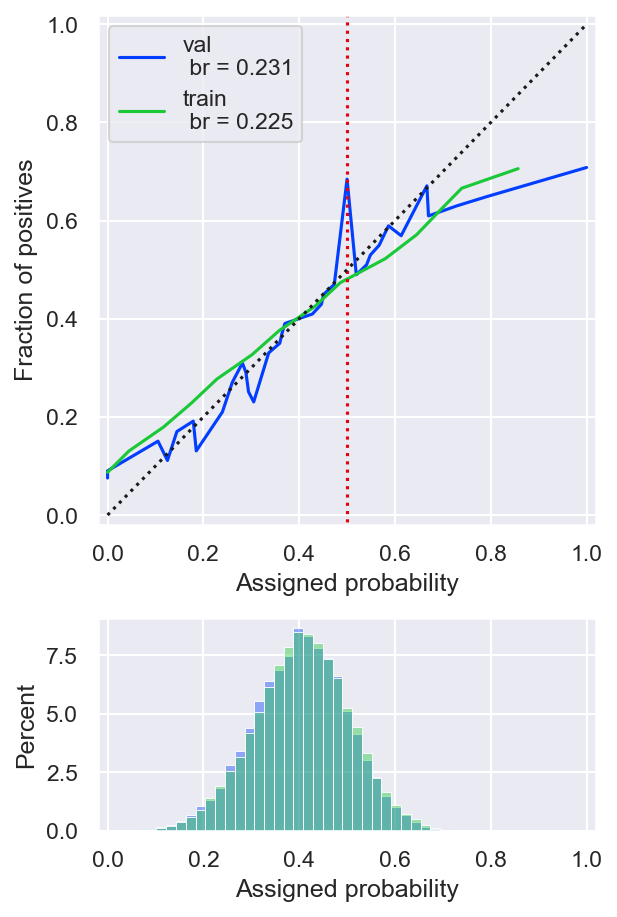

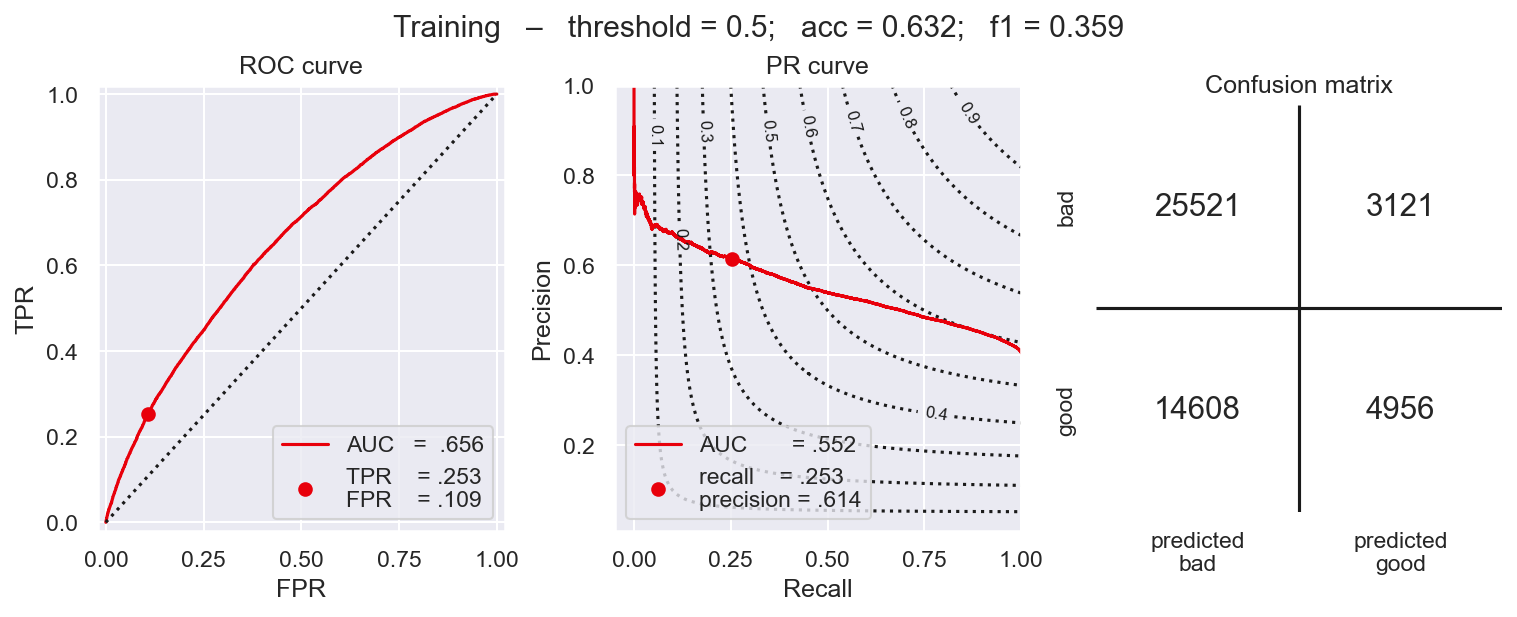

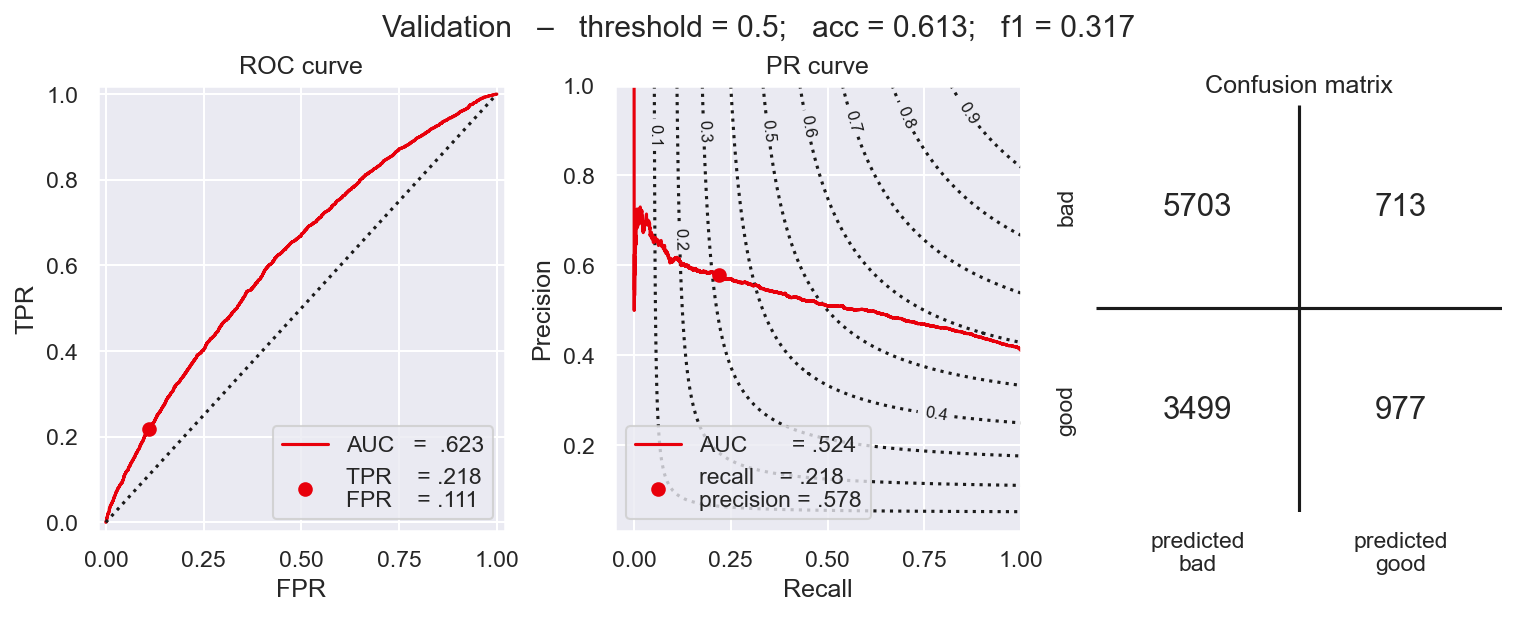

In [2]:
# %% calibration curves for validation and train sets
model = joblib.load('models/model_v3.pkl')
train_prob_pred = pd.Series(
    model.predict_proba(train_X)[:, 1],
    index=train_X.index
    )
val_prob_pred = pd.Series(model.predict_proba(val_X)[:, 1], index=val_X.index)

plot_calibration_curves(train_prob_pred, val_prob_pred, train_y, val_y)

plot_ROC_PRC_conf(train_prob_pred, train_y, sup_tit='Training')

plot_ROC_PRC_conf(val_prob_pred, val_y, sup_tit='Validation')


# Inspect the model

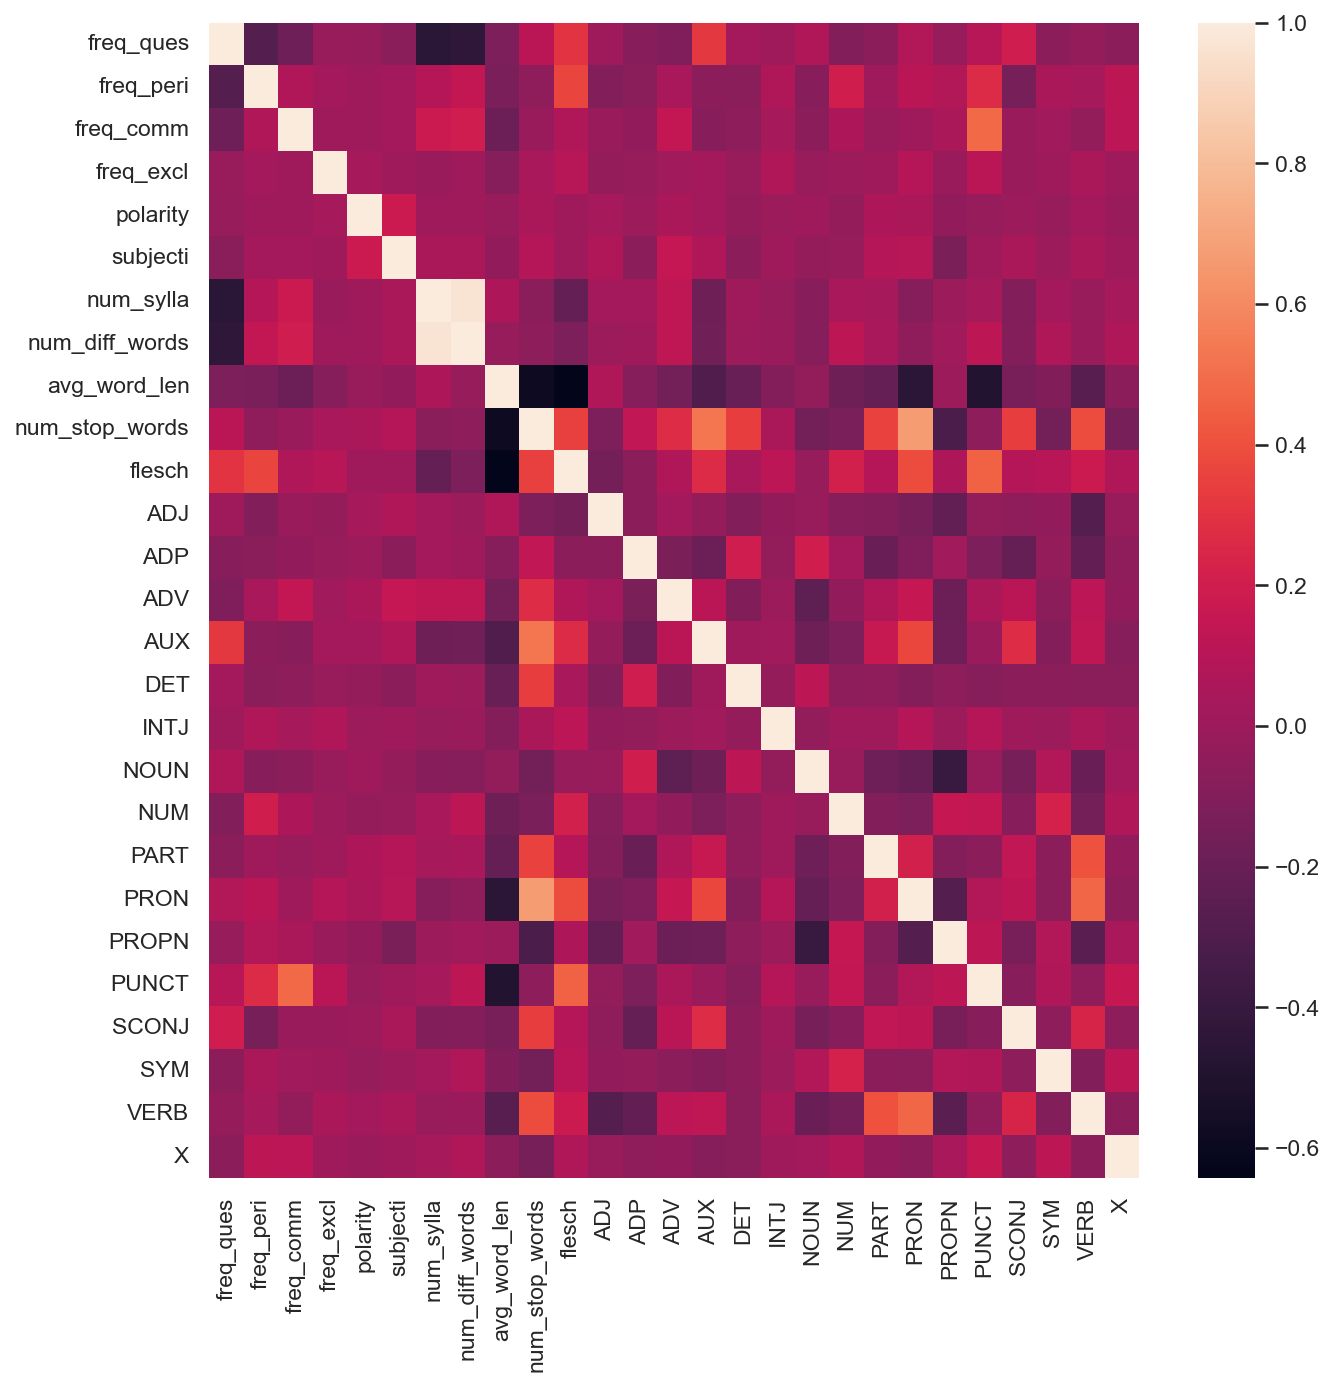

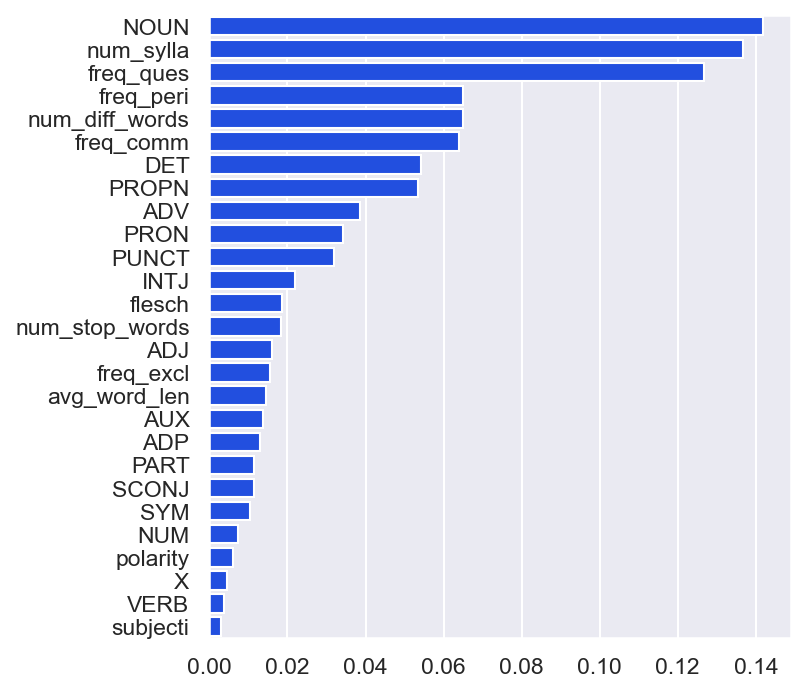

In [3]:
plot_train_feature_correlation(train_X)

plot_model_feature_importances(model, FEATURE_NAMES)